In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/공모전/'

Mounted at /content/drive


In [4]:
df = pd.read_csv(path + 'dataset/train_heat.csv')
df

,Unnamed: 0,train_heat.tm,train_heat.branch_id,train_heat.ta,train_heat.wd,train_heat.ws,train_heat.rn_day,train_heat.rn_hr1,train_heat.hm,train_heat.si,train_heat.ta_chi,train_heat.heat_demand
0,1,2021010101,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281
1,2,2021010102,A,-10.2,71.9,0.6,0.0,0.0,69.9,-99.0,-8.6,262
2,3,2021010103,A,-10.0,360.0,0.0,0.0,0.0,69.2,-99.0,-8.8,266
3,4,2021010104,A,-9.3,155.9,0.5,0.0,0.0,65.0,-99.0,-8.9,285
4,5,2021010105,A,-9.0,74.3,1.9,0.0,0.0,63.5,-99.0,-9.2,283
...,...,...,...,...,...,...,...,...,...,...,...,...
499296,499297,2023123119,S,3.2,233.5,0.4,2.5,0.0,91.5,-99.0,2.8,34
499297,499298,2023123120,S,2.9,227.4,0.1,2.5,0.0,92.1,-99.0,2.7,35
499298,499299,2023123121,S,2.1,360.0,0.0,2.5,0.0,93.3,-99.0,1.4,35
499299,499300,2023123122,S,2.2,30.0,1.4,2.5,0.0,95.5,-99.0,1.3,40


In [5]:
# 데이터 불러오기 및 컬럼 정리
# df = pd.read_csv('dataset/train_heat.csv')  # CSV 파일 로드
df.drop(columns='Unnamed: 0', inplace=True)  # 저장 과정에서 자동 생성된 불필요한 인덱스 컬럼 제거
df.columns = [col.replace('train_heat.','') for col in df.columns]  # 컬럼명에서 접두어 제거 → 추후 코드 간결화 목적
print(df.columns)
df.info()  # 결측치, 데이터 타입 등 구조 확인

Index(['tm', 'branch_id', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si',
       'ta_chi', 'heat_demand'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   tm           499301 non-null  int64  
 1   branch_id    499301 non-null  object 
 2   ta           499301 non-null  float64
 3   wd           499301 non-null  float64
 4   ws           499301 non-null  float64
 5   rn_day       499301 non-null  float64
 6   rn_hr1       499301 non-null  float64
 7   hm           499301 non-null  float64
 8   si           499301 non-null  float64
 9   ta_chi       499301 non-null  float64
 10  heat_demand  499301 non-null  int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 41.9+ MB


In [6]:
# 시간 정보 처리 및 정렬
df['tm'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')  # 문자열 시간 컬럼을 datetime 타입으로 변환
df = df.sort_values(['branch_id', 'tm'])  # 지점별로 시간 순 정렬 → 시간 기반 보간 및 시계열 분석에 필수

In [7]:
# 이상값 처리 (-99.0을 NaN으로 변경) 및 결측 비율 확인
df_nan = df.replace(-99.0, np.nan)  # 기상 데이터에서 -99.0은 측정 실패를 의미하므로 NaN으로 대체
df_nan.isnull().sum()  # 결측값 개수 확인
nan_ratio = df_nan.isnull().mean()  # 전체 대비 결측 비율 계산
nan_ratio.sort_values(ascending=False)


,0
si,0.466496
hm,0.079545
rn_hr1,0.038362
ws,0.037683
wd,0.037683
rn_day,0.037304
ta,0.026030
heat_demand,0.000046
ta_chi,0.000040
branch_id,0.000000


In [8]:
# 분석 대상 컬럼 선택
df_select = df_nan.copy()
df_select.drop(columns='si', inplace=True)  # 결측치 비율이 높은 'si' 컬럼은 모델에 불필요하다고 판단
df_select.dropna(subset=['heat_demand'], inplace=True)  # 타겟값 없는 행 제거 (학습 불가)

In [9]:
# 시간 기반 보간 준비
df_select = df_select.set_index('tm')  # 시간 기반 보간을 위해 인덱스를 시간으로 설정

In [10]:
# 기상 변수(time_interp_cols)에 대해 지점별 시간 보간
time_interp_cols = ['ta', 'ta_chi', 'ws', 'hm', 'rn_day']  # 온도, 풍속, 습도, 강수량 등 시간에 따라 연속적 변하는 변수
df_select[time_interp_cols] = df_select.groupby('branch_id')[time_interp_cols].transform(
    lambda group: group.interpolate(method='time')  # 시간 순서를 기준으로 선형 보간
)
df_select.isnull().sum()

,0
branch_id,0
ta,0
wd,18813
ws,0
rn_day,0
rn_hr1,19152
hm,23164
ta_chi,0
heat_demand,0


In [11]:
# 바람 방향(wd)은 각도 데이터이므로 선형 보간 어려움 → sin, cos으로 변환하여 보간
wd_rad = np.deg2rad(df_select['wd'])  # 각도(0~360°)를 라디안으로 변환
df_select['wd_sin'] = np.sin(wd_rad)
df_select['wd_cos'] = np.cos(wd_rad)

# 지점별로 보간 → 극좌표 성분이므로 time 보간이 안정적
df_select['wd_sin'] = df_select.groupby('branch_id')['wd_sin'].transform(lambda g: g.interpolate(method='time'))
df_select['wd_cos'] = df_select.groupby('branch_id')['wd_cos'].transform(lambda g: g.interpolate(method='time'))

df_select.drop(columns=['wd'], inplace=True)  # 원래 wd 컬럼 제거

In [12]:
# 보간 결과 복사 후 결측 재확인
df_interp = df_select.copy()
df_interp.isnull().sum()

,0
branch_id,0
ta,0
ws,0
rn_day,0
rn_hr1,19152
hm,23164
ta_chi,0
heat_demand,0
wd_sin,0
wd_cos,0


In [13]:
# rn_hr1 결측은 비가 오지 않은 것으로 간주하고 0으로 대체
df_interp['rn_hr1'] = df_interp['rn_hr1'].fillna(0)  # 1시간 강수량 측정 실패는 '강수 없음'으로 처리
df_interp.isnull().sum()

,0
branch_id,0
ta,0
ws,0
rn_day,0
rn_hr1,0
hm,23164
ta_chi,0
heat_demand,0
wd_sin,0
wd_cos,0


In [14]:
# 강수 이벤트 생성 변수
# rn_day_diff: 누적 강수량의 변화량 (강수 발생 감지용)
df_interp['rn_day_diff'] = df_interp.groupby('branch_id')['rn_day'].diff().fillna(0)

# rain_flag: 강수 이벤트 여부 (rn_hr1 > 0 또는 rn_day_diff > 0인 경우 1, 아니면 0)
df_interp['rain_flag'] = ((df_interp['rn_hr1'] > 0) | (df_interp['rn_day_diff'] > 0)).astype(int)

In [15]:
# 11. 강수 여부에 따른 습도 통계 계산
# - 비 오는 날 평균 습도, 비 안 오는 날 중앙값 습도 → 이후 결측값 대체에 활용
hm_rainy = df_interp[df_interp['rain_flag'] == 1].groupby('branch_id')['hm'].mean().rename('hm_rainy_mean')
hm_dry = df_interp[df_interp['rain_flag'] == 0].groupby('branch_id')['hm'].median().rename('hm_dry_median')
hm_stats = pd.concat([hm_rainy, hm_dry], axis=1).reset_index()

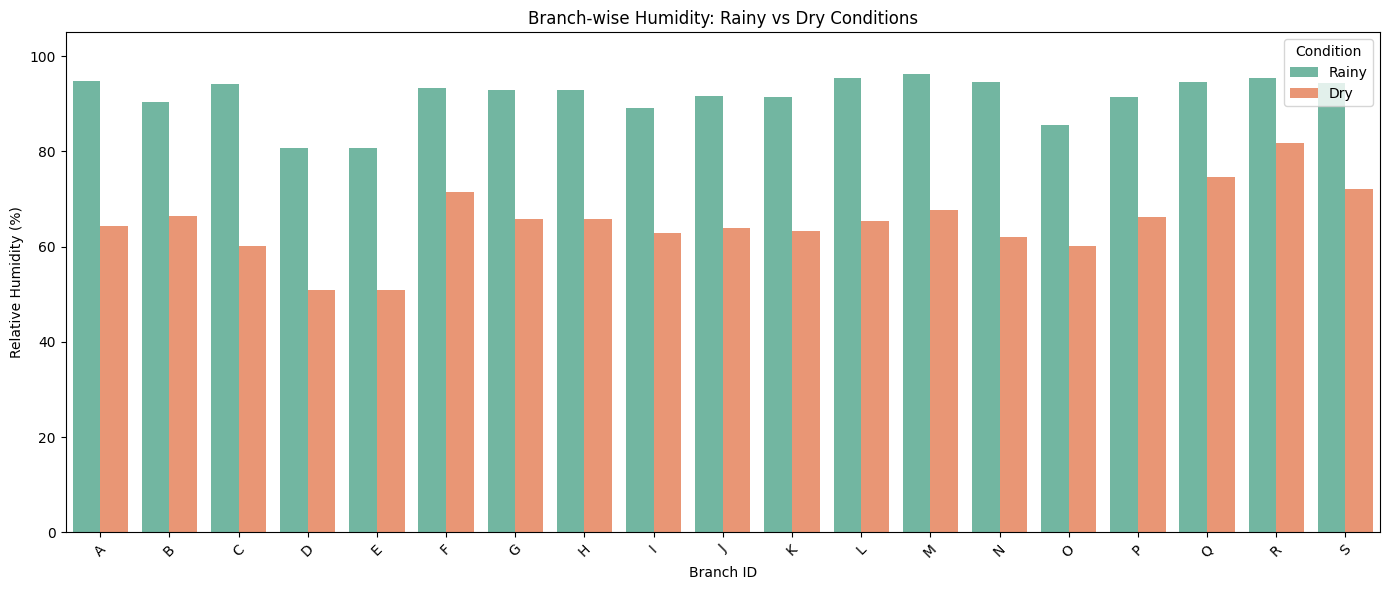

In [16]:
# 지점별 습도 분포 시각화 (강수 여부별)
hm_melted = hm_stats.melt(id_vars='branch_id',
                          value_vars=['hm_rainy_mean', 'hm_dry_median'],
                          var_name='Rain_Status',
                          value_name='Humidity')
hm_melted['Rain_Status'] = hm_melted['Rain_Status'].map({
    'hm_rainy_mean': 'Rainy',
    'hm_dry_median': 'Dry'
})

plt.figure(figsize=(14, 6))
sns.barplot(data=hm_melted, x='branch_id', y='Humidity', hue='Rain_Status', palette='Set2')
plt.title('Branch-wise Humidity: Rainy vs Dry Conditions')
plt.xlabel('Branch ID')
plt.ylabel('Relative Humidity (%)')
plt.ylim(0, 105)
plt.legend(title='Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# 결측 습도(hm) 보완 함수 정의
# rain_flag 기준으로 지점별 평균/중앙값으로 채움
rainy_dict = dict(zip(hm_stats['branch_id'], hm_stats['hm_rainy_mean']))
dry_dict = dict(zip(hm_stats['branch_id'], hm_stats['hm_dry_median']))

def fill_hm_branchwise(row):
    if pd.notnull(row['hm']):
        return row['hm']
    bid = row['branch_id']
    if row['rain_flag'] == 1:
        return rainy_dict.get(bid, 90.0)  # fallback: 90%
    else:
        return dry_dict.get(bid, 60.0)  # fallback: 60%


In [18]:
# 결측값 채우기 및 최종 확인
df_interp['hm'] = df_interp.apply(fill_hm_branchwise, axis=1)
display(df_interp)
print(df_interp.isnull().sum())

,branch_id,ta,ws,rn_day,rn_hr1,hm,ta_chi,heat_demand,wd_sin,wd_cos,rn_day_diff,rain_flag
tm,,,,,,,,,,,,
2021-01-01 01:00:00,A,-10.1,0.5,0.0,0.0,68.2,-8.2,281.0,9.792228e-01,0.202787,0.0,0
2021-01-01 02:00:00,A,-10.2,0.6,0.0,0.0,69.9,-8.6,262.0,9.505157e-01,0.310676,0.0,0
2021-01-01 03:00:00,A,-10.0,0.0,0.0,0.0,69.2,-8.8,266.0,-2.449294e-16,1.000000,0.0,0
2021-01-01 04:00:00,A,-9.3,0.5,0.0,0.0,65.0,-8.9,285.0,4.083305e-01,-0.912834,0.0,0
2021-01-01 05:00:00,A,-9.0,1.9,0.0,0.0,63.5,-9.2,283.0,9.626917e-01,0.270600,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,S,3.2,0.4,2.5,0.0,91.5,2.8,34.0,-8.038569e-01,-0.594823,0.0,0
2023-12-31 20:00:00,S,2.9,0.1,2.5,0.0,92.1,2.7,35.0,-7.360971e-01,-0.676876,0.0,0
2023-12-31 21:00:00,S,2.1,0.0,2.5,0.0,93.3,1.4,35.0,-2.449294e-16,1.000000,0.0,0


branch_id      0
ta             0
ws             0
rn_day         0
rn_hr1         0
hm             0
ta_chi         0
heat_demand    0
wd_sin         0
wd_cos         0
rn_day_diff    0
rain_flag      0
dtype: int64


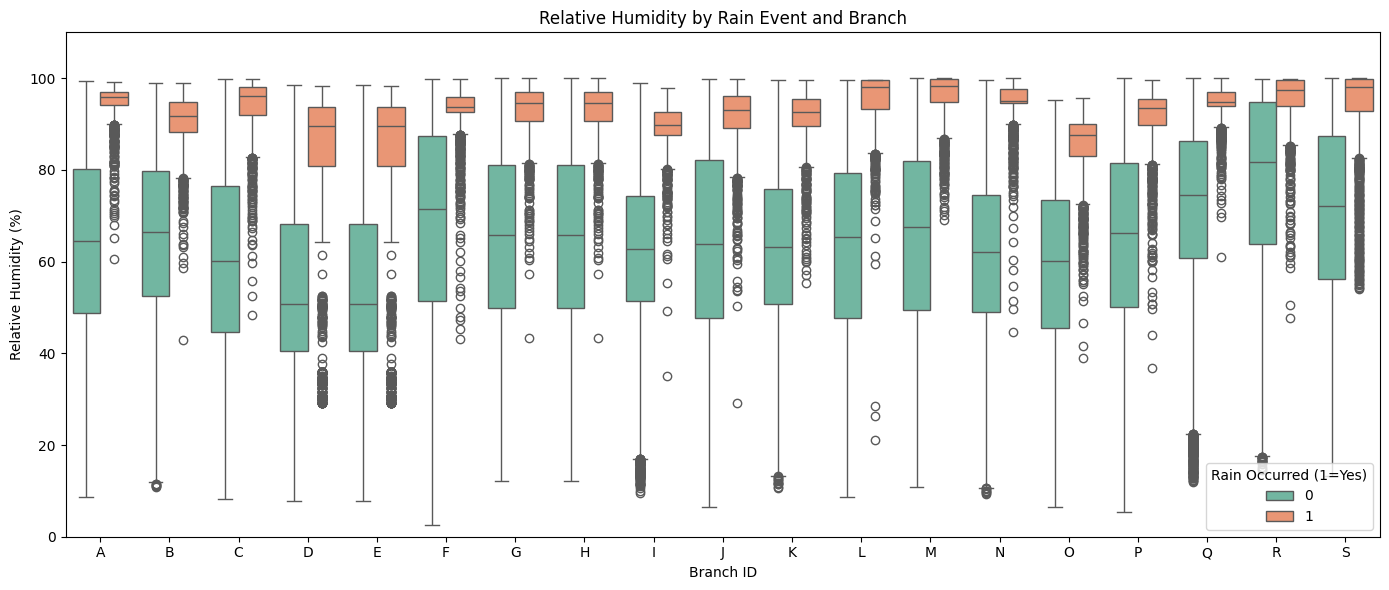

In [19]:
# 최종 습도 분포 시각화 (지점별 + rain_flag 기준)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_interp, x='branch_id', y='hm', hue='rain_flag', palette='Set2')
plt.title('Relative Humidity by Rain Event and Branch')
plt.xlabel('Branch ID')
plt.ylabel('Relative Humidity (%)')
plt.ylim(0, 110)
plt.legend(title='Rain Occurred (1=Yes)')
plt.tight_layout()
plt.show()


In [20]:
# 인덱스 정리 및 날짜 기반 파생 변수 생성

# 모델링 이전 단계에서 인덱스가 시간(tm)인 상태였다면 다시 일반 컬럼으로 되돌림
if df_interp.index.name == 'tm':
    df_interp.reset_index(inplace=True)

# 시간 관련 파생 변수 생성: 수요 패턴이 시간대/요일/월별로 다를 수 있기 때문
df_interp['hour'] = df_interp['tm'].dt.hour       # 하루 중 시간대
df_interp['month'] = df_interp['tm'].dt.month     # 월 (계절성 반영)
df_interp['weekday'] = df_interp['tm'].dt.weekday # 요일 (주말/평일 패턴 반영)

In [21]:
# 수치형 변수의 왜도 분석

# 수치형 변수만 선택 (로그 변환 및 정규성 확인용)
numeric_cols = df_interp.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# 각 컬럼별 왜도 계산 (정규분포에서 벗어난 정도 측정)
from scipy.stats import skew
skew_results = {
    col: skew(df_interp[col].dropna()) for col in numeric_cols
}
skew_df = pd.DataFrame.from_dict(skew_results, orient='index', columns=['skewness'])
skew_df = skew_df.sort_values(by='skewness', ascending=False)


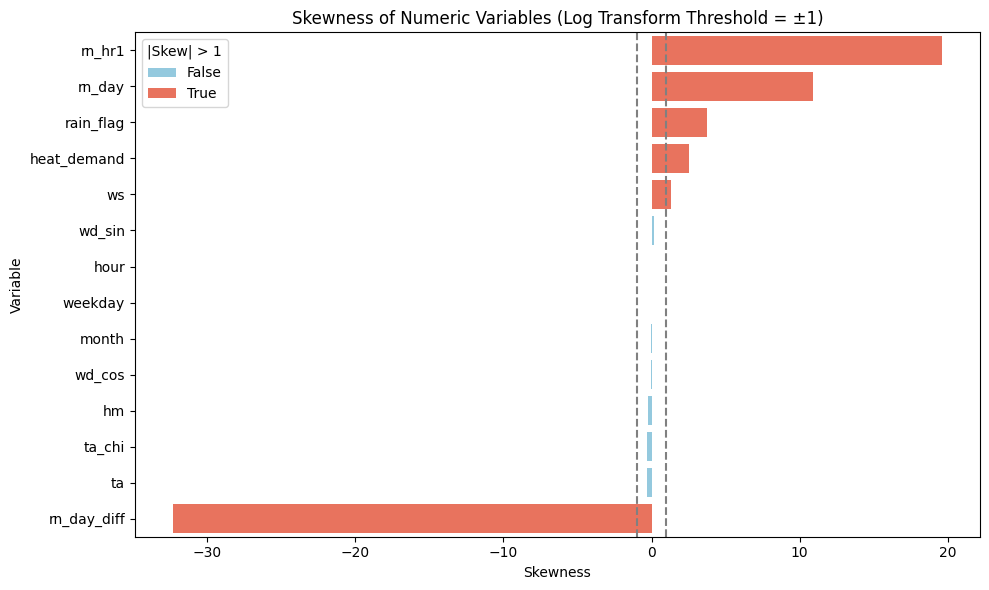

In [22]:
# 왜도 시각화: 왜도 절댓값 > 1인 경우 로그 변환 후보로 간주

# 막대그래프용 정리
skew_df_sorted = skew_df.copy().reset_index()
skew_df_sorted.columns = ['Variable', 'Skewness']
skew_df_sorted['Highlight'] = skew_df_sorted['Skewness'].abs() > 1

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=skew_df_sorted, x='Skewness', y='Variable', hue='Highlight', dodge=False, palette={True: 'tomato', False: 'skyblue'})
plt.axvline(x=1, color='gray', linestyle='--')
plt.axvline(x=-1, color='gray', linestyle='--')
plt.title('Skewness of Numeric Variables (Log Transform Threshold = ±1)')
plt.xlabel('Skewness')
plt.ylabel('Variable')
plt.legend(title='|Skew| > 1')
plt.tight_layout()
plt.show()


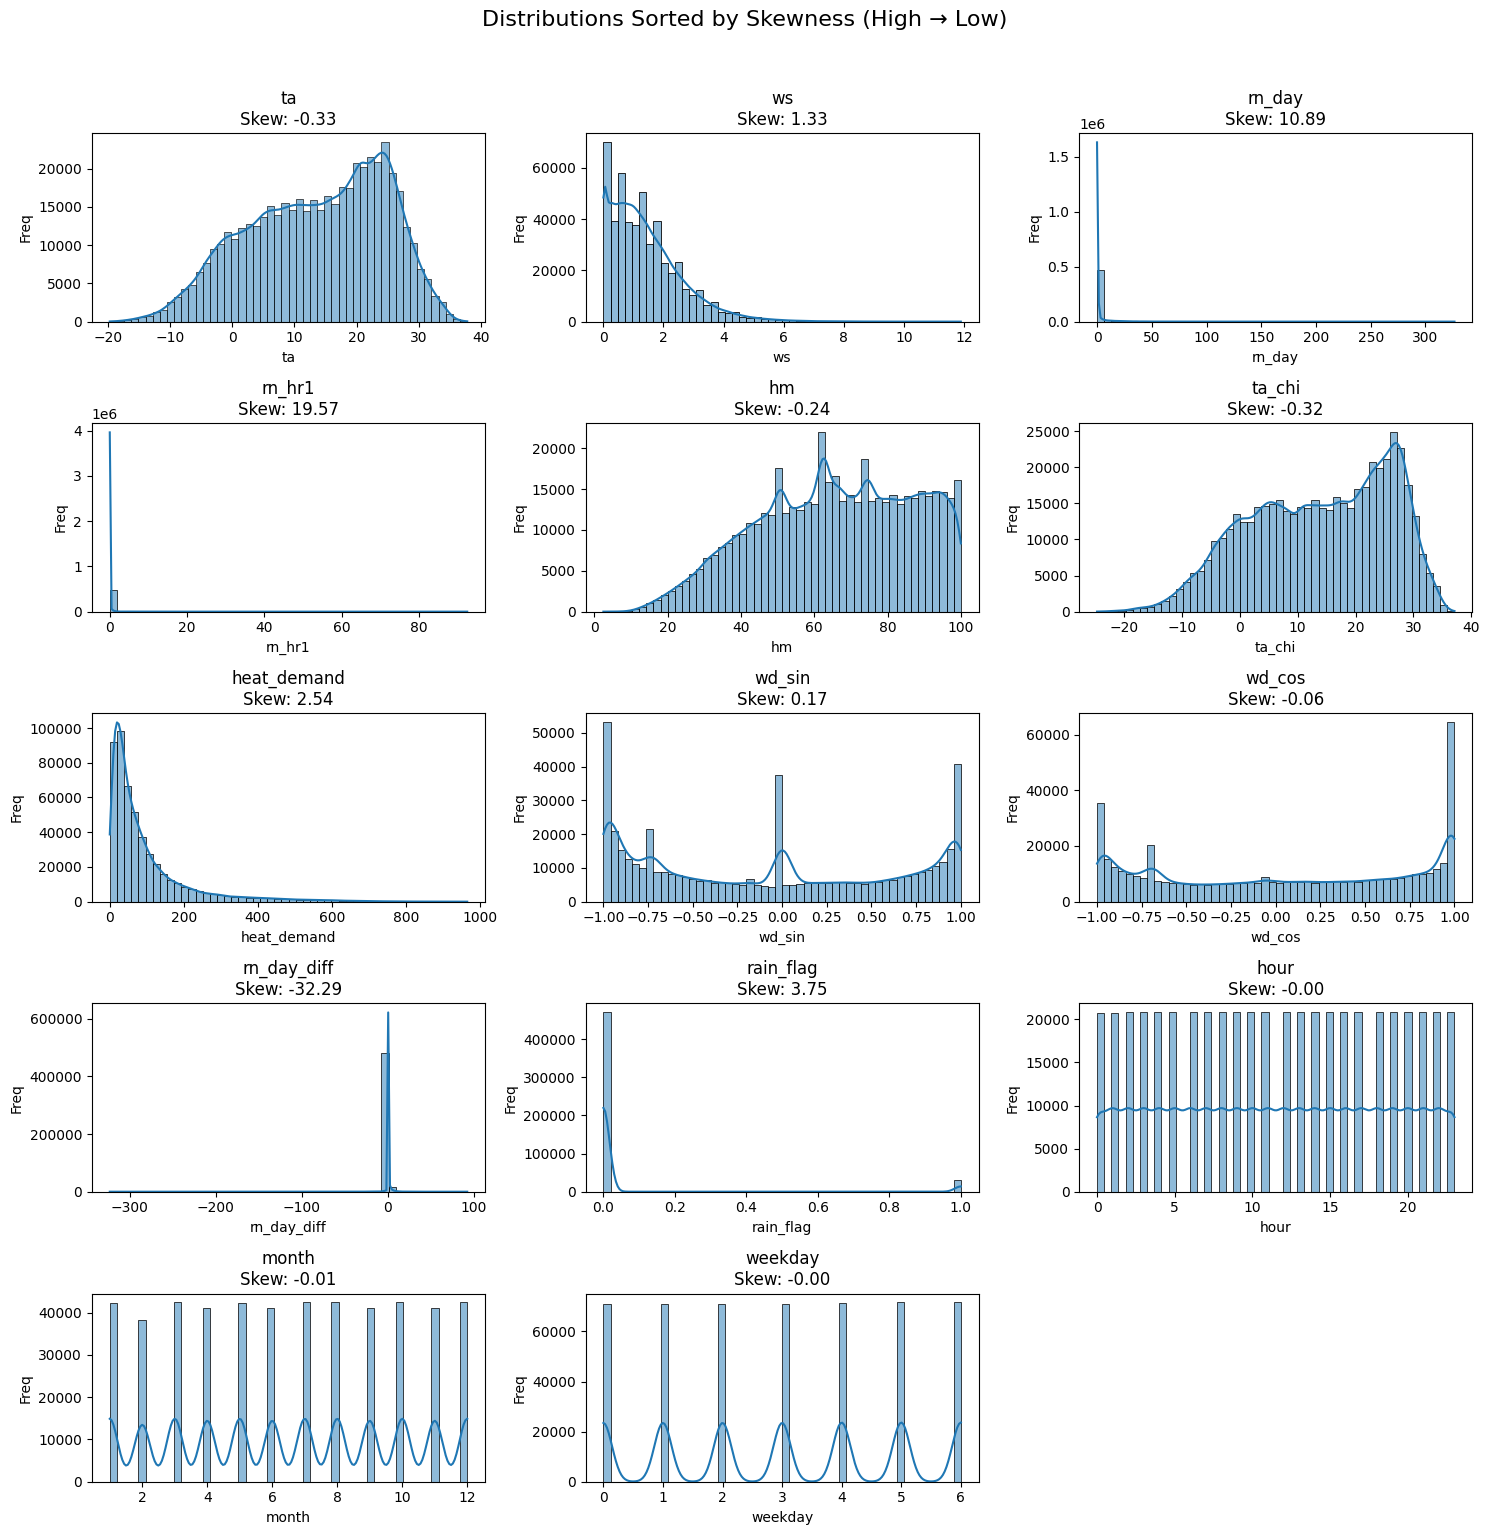

In [23]:
# 왜도 높은 변수의 분포 히스토그램

import math
n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 3))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_interp[col].dropna(), bins=50, kde=True)
    skew_val = skew_df.loc[col, 'skewness']
    plt.title(f'{col}\nSkew: {skew_val:.2f}')
    plt.xlabel(col)
    plt.ylabel('Freq')
    plt.tight_layout()
plt.suptitle('Distributions Sorted by Skewness (High → Low)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [24]:
# 로그 변환 대상 변수 선정

# 로그 변환 기준: 왜도 > 1 이면서 음수 값이 없는 경우
log_transform_cols = [
    col for col in skew_df.index
    if skew_df.loc[col, 'skewness'] > 1
    and df_interp[col].min() >= 0
    and df_interp[col].nunique() > 2
]
print("로그 변환 대상:", log_transform_cols)

# 로그 변환 수행: log1p 사용 (log(x+1), 0 처리 가능)
for col in log_transform_cols:
    df_interp[f'{col}_log'] = np.log1p(df_interp[col])
    print(f"Log-transformed: {col} → {col}_log")


로그 변환 대상: ['rn_hr1', 'rn_day', 'heat_demand', 'ws']
Log-transformed: rn_hr1 → rn_hr1_log
Log-transformed: rn_day → rn_day_log
Log-transformed: heat_demand → heat_demand_log
Log-transformed: ws → ws_log


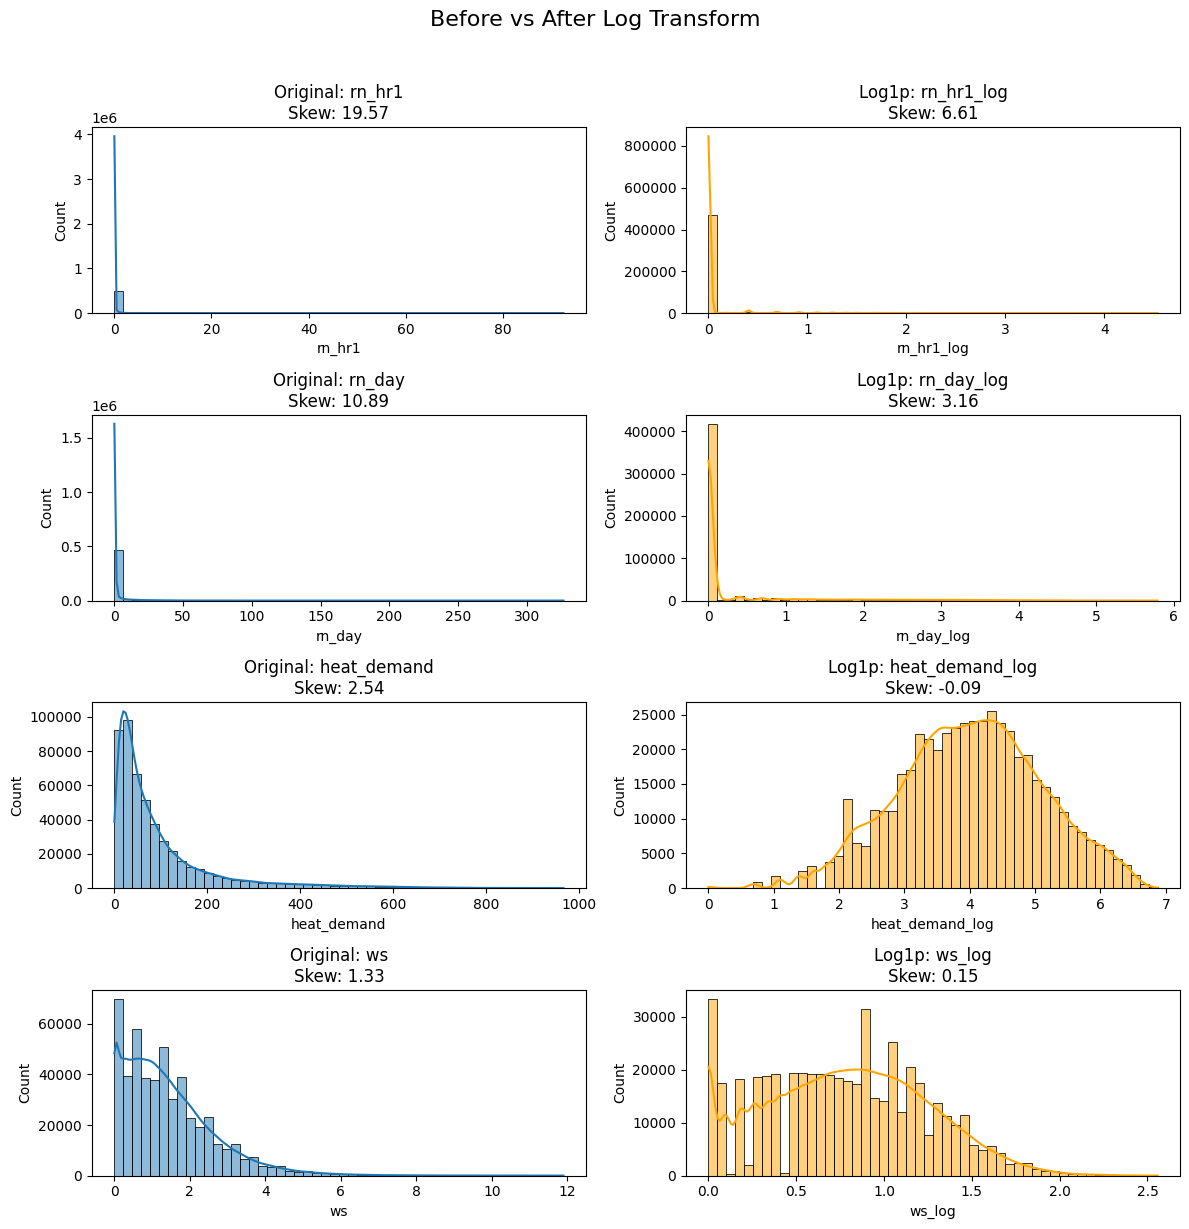

In [25]:
# 로그 변환 전후 분포 비교

n_cols = 2
n_rows = len(log_transform_cols)
plt.figure(figsize=(n_cols * 6, n_rows * 3))

for i, col in enumerate(log_transform_cols):
    # 원본
    plt.subplot(n_rows, n_cols, 2*i + 1)
    sns.histplot(df_interp[col].dropna(), bins=50, kde=True)
    plt.title(f'Original: {col}\nSkew: {skew_df.loc[col, "skewness"]:.2f}')

    # 로그 변환
    plt.subplot(n_rows, n_cols, 2*i + 2)
    sns.histplot(df_interp[f'{col}_log'].dropna(), bins=50, kde=True, color='orange')
    new_skew = skew(df_interp[f'{col}_log'].dropna())
    plt.title(f'Log1p: {col}_log\nSkew: {new_skew:.2f}')

plt.suptitle('Before vs After Log Transform', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [26]:
df_interp.drop(columns=log_transform_cols, inplace=True)

In [27]:
df_interp.columns

Index(['tm', 'branch_id', 'ta', 'hm', 'ta_chi', 'wd_sin', 'wd_cos',
       'rn_day_diff', 'rain_flag', 'hour', 'month', 'weekday', 'rn_hr1_log',
       'rn_day_log', 'heat_demand_log', 'ws_log'],
      dtype='object')

test_heat 전처리

In [28]:
df_test = pd.read_csv(path + 'dataset/test_heat.csv')
df_test_all = df_test.copy()
original_columns = df_test_all.columns.tolist()

# 시간 정보 처리 및 정렬
df_test['TM'] = pd.to_datetime(df_test['TM'], format='%Y%m%d%H')  # 문자열 시간 컬럼을 datetime 타입으로 변환
df_test = df_test.sort_values(['branch_ID', 'TM'])  # 지점별로 시간 순 정렬 → 시간 기반 보간 및 시계열 분석에 필수

# 이상값 처리 (-99.0을 NaN으로 변경) 및 결측 비율 확인
df_nan_test = df_test.replace(-99.0, np.nan)  # 기상 데이터에서 -99.0은 측정 실패를 의미하므로 NaN으로 대체
df_nan_test.isnull().sum()  # 결측값 개수 확인
nan_ratio_test = df_nan_test.isnull().mean()  # 전체 대비 결측 비율 계산
nan_ratio_test.sort_values(ascending=False)

# 분석 대상 컬럼 선택
df_select_test = df_nan_test.copy()
df_select_test.drop(columns='SI', inplace=True)  # 결측치 비율이 높은 'si' 컬럼은 모델에 불필요하다고 판단
# df_select.dropna(subset=['heat_demand'], inplace=True)  # 타겟값 없는 행 제거 (학습 불가)

# 시간 기반 보간 준비
df_select_test = df_select_test.set_index('TM')  # 시간 기반 보간을 위해 인덱스를 시간으로 설정

# 기상 변수(time_interp_cols)에 대해 지점별 시간 보간
time_interp_cols = ['TA', 'ta_chi', 'WS', 'HM', 'RN_DAY']  # 온도, 풍속, 습도, 강수량 등 시간에 따라 연속적 변하는 변수
df_select_test[time_interp_cols] = df_select_test.groupby('branch_ID')[time_interp_cols].transform(
    lambda group: group.interpolate(method='time')  # 시간 순서를 기준으로 선형 보간
)
df_select.isnull().sum()

# 바람 방향(wd)은 각도 데이터이므로 선형 보간 어려움 → sin, cos으로 변환하여 보간
wd_rad = np.deg2rad(df_select_test['WD'])  # 각도(0~360°)를 라디안으로 변환
df_select_test['wd_sin'] = np.sin(wd_rad)
df_select_test['wd_cos'] = np.cos(wd_rad)

# 지점별로 보간 → 극좌표 성분이므로 time 보간이 안정적
df_select_test['wd_sin'] = df_select_test.groupby('branch_ID')['wd_sin'].transform(lambda g: g.interpolate(method='time'))
df_select_test['wd_cos'] = df_select_test.groupby('branch_ID')['wd_cos'].transform(lambda g: g.interpolate(method='time'))

df_select_test.drop(columns=['WD'], inplace=True)  # 원래 wd 컬럼 제거

# 보간 결과 복사 후 결측 재확인
df_interp_test = df_select_test.copy()
df_interp_test.isnull().sum()

# rn_hr1 결측은 비가 오지 않은 것으로 간주하고 0으로 대체
df_interp_test['RN_HR1'] = df_interp_test['RN_HR1'].fillna(0)  # 1시간 강수량 측정 실패는 '강수 없음'으로 처리
df_interp_test.isnull().sum()

# 강수 이벤트 생성 변수
# rn_day_diff: 누적 강수량의 변화량 (강수 발생 감지용)
df_interp_test['rn_day_diff'] = df_interp_test.groupby('branch_ID')['RN_DAY'].diff().fillna(0)

# rain_flag: 강수 이벤트 여부 (rn_hr1 > 0 또는 rn_day_diff > 0인 경우 1, 아니면 0)
df_interp_test['rain_flag'] = ((df_interp_test['RN_HR1'] > 0) | (df_interp_test['rn_day_diff'] > 0)).astype(int)


# 강수 여부에 따른 습도 통계 계산
# - 비 오는 날 평균 습도, 비 안 오는 날 중앙값 습도 → 이후 결측값 대체에 활용
hm_rainy = df_interp_test[df_interp_test['rain_flag'] == 1].groupby('branch_ID')['HM'].mean().rename('hm_rainy_mean')
hm_dry = df_interp_test[df_interp_test['rain_flag'] == 0].groupby('branch_ID')['HM'].median().rename('hm_dry_median')
hm_stats_test = pd.concat([hm_rainy, hm_dry], axis=1).reset_index()

# 결측 습도(hm) 보완 함수 정의
# rain_flag 기준으로 지점별 평균/중앙값으로 채움
rainy_dict = dict(zip(hm_stats_test['branch_ID'], hm_stats_test['hm_rainy_mean']))
dry_dict = dict(zip(hm_stats_test['branch_ID'], hm_stats_test['hm_dry_median']))

def fill_hm_branchwise(row):
    if pd.notnull(row['HM']):
        return row['HM']
    bid = row['branch_ID']
    if row['rain_flag'] == 1:
        return rainy_dict.get(bid, 90.0)  # fallback: 90%
    else:
        return dry_dict.get(bid, 60.0)  # fallback: 60%

# 결측값 채우기 및 최종 확인
df_interp_test['HM'] = df_interp_test.apply(fill_hm_branchwise, axis=1)

missing_rnday = df_interp_test[df_interp_test['RN_DAY'].isna()]
def fill_rnday_first_hour(df):
    df = df.copy()

    # index를 datetime 컬럼으로 변환
    df = df.reset_index()

    # 마스크 조건: 2024-01-01 00시, branch C/D/E/F, RN_DAY가 결측
    mask = (
        (df['TM'] == pd.to_datetime('2024-01-01 00:00:00')) &
        (df['branch_ID'].isin(['C', 'D', 'E', 'F'])) &
        (df['RN_DAY'].isna())
    )

    for i in df[mask].index:
        branch = df.loc[i, 'branch_ID']
        next_time = df.loc[i, 'TM'] + pd.Timedelta(hours=1)

        # 같은 branch의 다음 시각 값이 존재하면 그 값으로 대체
        match = df[(df['branch_ID'] == branch) & (df['TM'] == next_time)]
        if not match.empty:
            df.at[i, 'RN_DAY'] = match['RN_DAY'].values[0]
        else:
            df.at[i, 'RN_DAY'] = 0  # 대체 값

    df = df.set_index('TM')
    return df

df_interp_test = fill_rnday_first_hour(df_interp_test)
df_interp_test.isnull().sum()

# 인덱스 정리 및 날짜 기반 파생 변수 생성

# 모델링 이전 단계에서 인덱스가 시간(tm)인 상태였다면 다시 일반 컬럼으로 되돌림
if df_interp_test.index.name == 'TM':
    df_interp_test.reset_index(inplace=True)

# 시간 관련 파생 변수 생성: 수요 패턴이 시간대/요일/월별로 다를 수 있기 때문
df_interp_test['hour'] = df_interp_test['TM'].dt.hour       # 하루 중 시간대
df_interp_test['month'] = df_interp_test['TM'].dt.month     # 월 (계절성 반영)
df_interp_test['weekday'] = df_interp_test['TM'].dt.weekday # 요일 (주말/평일 패턴 반영)

# 수치형 변수의 왜도 분석

# 수치형 변수만 선택 (로그 변환 및 정규성 확인용)
numeric_cols = df_interp_test.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# 각 컬럼별 왜도 계산 (정규분포에서 벗어난 정도 측정)
from scipy.stats import skew
skew_results = {
    col: skew(df_interp_test[col].dropna()) for col in numeric_cols
}
skew_df = pd.DataFrame.from_dict(skew_results, orient='index', columns=['skewness'])
skew_df = skew_df.sort_values(by='skewness', ascending=False)


# 로그 변환 대상 변수 선정

# 로그 변환 기준: 왜도 > 1 이면서 음수 값이 없는 경우
log_transform_cols = [
    col for col in skew_df.index
    if skew_df.loc[col, 'skewness'] > 1
    and df_interp_test[col].min() >= 0
    and df_interp_test[col].nunique() > 2
]
print("로그 변환 대상:", log_transform_cols)

# 로그 변환 수행: log1p 사용 (log(x+1), 0 처리 가능)
for col in log_transform_cols:
    df_interp_test[f'{col}_log'] = np.log1p(df_interp_test[col])
    print(f"Log-transformed: {col} → {col}_log")

df_interp_test.drop(columns=log_transform_cols, inplace=True)

df_test = df_interp_test.copy()
df_test.columns

로그 변환 대상: ['RN_HR1', 'RN_DAY', 'WS']
Log-transformed: RN_HR1 → RN_HR1_log
Log-transformed: RN_DAY → RN_DAY_log
Log-transformed: WS → WS_log


Index(['TM', 'branch_ID', 'TA', 'HM', 'ta_chi', 'heat_demand', 'wd_sin',
       'wd_cos', 'rn_day_diff', 'rain_flag', 'hour', 'month', 'weekday',
       'RN_HR1_log', 'RN_DAY_log', 'WS_log'],
      dtype='object')

In [29]:
# test_df 컬럼명 통일 (대소문자 통일 + 일부 컬럼 매핑)
def standardize_test_columns(test_df):
    column_mapping = {
        'TM': 'tm',
        'branch_ID': 'branch_id',
        'TA': 'ta',
        'HM': 'hm',
        'RN_HR1_log': 'rn_hr1_log',
        'RN_DAY_log': 'rn_day_log',
        'WS_log': 'ws_log',
        'heat_demand': 'heat_demand'
    }

    test_df = test_df.rename(columns=column_mapping)
    test_df.columns = test_df.columns.str.lower()
    return test_df

df_test = standardize_test_columns(df_test)

In [30]:
df_enhanced = df_interp.copy()
df_enhanced = df_enhanced.sort_values(['branch_id', 'tm'])
df_enhanced

,tm,branch_id,ta,hm,ta_chi,wd_sin,wd_cos,rn_day_diff,rain_flag,hour,month,weekday,rn_hr1_log,rn_day_log,heat_demand_log,ws_log
0,2021-01-01 01:00:00,A,-10.1,68.2,-8.2,9.792228e-01,0.202787,0.0,0,1,1,4,0.0,0.000000,5.641907,0.405465
1,2021-01-01 02:00:00,A,-10.2,69.9,-8.6,9.505157e-01,0.310676,0.0,0,2,1,4,0.0,0.000000,5.572154,0.470004
2,2021-01-01 03:00:00,A,-10.0,69.2,-8.8,-2.449294e-16,1.000000,0.0,0,3,1,4,0.0,0.000000,5.587249,0.000000
3,2021-01-01 04:00:00,A,-9.3,65.0,-8.9,4.083305e-01,-0.912834,0.0,0,4,1,4,0.0,0.000000,5.655992,0.405465
4,2021-01-01 05:00:00,A,-9.0,63.5,-9.2,9.626917e-01,0.270600,0.0,0,5,1,4,0.0,0.000000,5.648974,1.064711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499273,2023-12-31 19:00:00,S,3.2,91.5,2.8,-8.038569e-01,-0.594823,0.0,0,19,12,6,0.0,1.252763,3.555348,0.336472
499274,2023-12-31 20:00:00,S,2.9,92.1,2.7,-7.360971e-01,-0.676876,0.0,0,20,12,6,0.0,1.252763,3.583519,0.095310
499275,2023-12-31 21:00:00,S,2.1,93.3,1.4,-2.449294e-16,1.000000,0.0,0,21,12,6,0.0,1.252763,3.583519,0.000000
499276,2023-12-31 22:00:00,S,2.2,95.5,1.3,5.000000e-01,0.866025,0.0,0,22,12,6,0.0,1.252763,3.713572,0.875469


In [31]:
weather_cols = ['ta', 'hm', 'ws_log']
for col in weather_cols:
    for lag in [1, 3, 6, 12, 24]:
        df_enhanced[f'{col}_lag_{lag}'] = df_enhanced.groupby('branch_id')[col].shift(lag)

df_enhanced[[col for col in df_enhanced.columns if 'lag' in col]].head()

,rain_flag,ta_lag_1,ta_lag_3,ta_lag_6,ta_lag_12,ta_lag_24,hm_lag_1,hm_lag_3,hm_lag_6,hm_lag_12,hm_lag_24,ws_log_lag_1,ws_log_lag_3,ws_log_lag_6,ws_log_lag_12,ws_log_lag_24
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,-10.1,NaN,NaN,NaN,NaN,68.2,NaN,NaN,NaN,NaN,0.405465,NaN,NaN,NaN,NaN
2,0,-10.2,NaN,NaN,NaN,NaN,69.9,NaN,NaN,NaN,NaN,0.470004,NaN,NaN,NaN,NaN
3,0,-10.0,-10.1,NaN,NaN,NaN,69.2,68.2,NaN,NaN,NaN,0.000000,0.405465,NaN,NaN,NaN
4,0,-9.3,-10.2,NaN,NaN,NaN,65.0,69.9,NaN,NaN,NaN,0.405465,0.470004,NaN,NaN,NaN


In [32]:
target_col = 'heat_demand_log'

ma_periods = [12, 24, 72, 168]
for col in ['ta', 'hm']:
    for period in ma_periods:
        df_enhanced[f'{col}_ma_{period}'] = df_enhanced.groupby('branch_id')[col].rolling(
            window=period, min_periods=max(1, period//4)
        ).mean().reset_index(0, drop=True)

for col in ['ta', 'hm']:
    df_enhanced[f'{col}_pct_1h'] = df_enhanced.groupby('branch_id')[col].pct_change()
    df_enhanced[f'{col}_pct_6h'] = df_enhanced.groupby('branch_id')[col].pct_change(periods=6)
    df_enhanced[f'{col}_pct_24h'] = df_enhanced.groupby('branch_id')[col].pct_change(periods=24)

df_enhanced['hour'] = df_enhanced['tm'].dt.hour
df_enhanced['month'] = df_enhanced['tm'].dt.month
df_enhanced['weekday'] = df_enhanced['tm'].dt.weekday

df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
df_enhanced['month_sin'] = np.sin(2 * np.pi * (df_enhanced['month'] - 1) / 12)
df_enhanced['month_cos'] = np.cos(2 * np.pi * (df_enhanced['month'] - 1) / 12)
df_enhanced['weekday_sin'] = np.sin(2 * np.pi * df_enhanced['weekday'] / 7)
df_enhanced['weekday_cos'] = np.cos(2 * np.pi * df_enhanced['weekday'] / 7)

df_enhanced['is_weekend'] = (df_enhanced['weekday'] >= 5).astype(int)
df_enhanced['is_business_hour'] = ((df_enhanced['hour'] >= 9) & (df_enhanced['hour'] <= 18)).astype(int)
df_enhanced['is_morning_peak'] = df_enhanced['hour'].isin([6, 7, 8, 9]).astype(int)
df_enhanced['is_evening_peak'] = df_enhanced['hour'].isin([17, 18, 19, 20, 21]).astype(int)
df_enhanced['is_night'] = ((df_enhanced['hour'] >= 22) | (df_enhanced['hour'] <= 5)).astype(int)

df_enhanced['hdd_18'] = np.maximum(18 - df_enhanced['ta'], 0)
df_enhanced['hdd_20'] = np.maximum(20 - df_enhanced['ta'], 0)
df_enhanced['cdd_26'] = np.maximum(df_enhanced['ta'] - 26, 0)

df_enhanced['season_spring'] = df_enhanced['month'].isin([3, 4, 5]).astype(int)
df_enhanced['season_summer'] = df_enhanced['month'].isin([6, 7, 8]).astype(int)
df_enhanced['season_autumn'] = df_enhanced['month'].isin([9, 10, 11]).astype(int)
df_enhanced['season_winter'] = df_enhanced['month'].isin([12, 1, 2]).astype(int)
df_enhanced['heating_season'] = df_enhanced['month'].isin([11, 12, 1, 2, 3, 4]).astype(int)

df_enhanced['temp_hour_interaction'] = df_enhanced['ta'] * df_enhanced['hour_sin']
df_enhanced['temp_weekend_interaction'] = df_enhanced['ta'] * df_enhanced['is_weekend']
df_enhanced['temp_season_interaction'] = df_enhanced['ta'] * df_enhanced['heating_season']
df_enhanced['discomfort_index'] = df_enhanced['ta'] + 0.36 * df_enhanced['hm']

df_enhanced['ta_rolling_std_24h'] = df_enhanced.groupby('branch_id')['ta'].rolling(
    window=24, min_periods=6).std().reset_index(0, drop=True)

df_enhanced['ta_rolling_max_24h'] = df_enhanced.groupby('branch_id')['ta'].rolling(
    window=24, min_periods=6).max().reset_index(0, drop=True)

df_enhanced['ta_rolling_min_24h'] = df_enhanced.groupby('branch_id')['ta'].rolling(
    window=24, min_periods=6).min().reset_index(0, drop=True)

df_enhanced['ta_daily_range'] = df_enhanced['ta_rolling_max_24h'] - df_enhanced['ta_rolling_min_24h']

df_enhanced.drop(columns=['hour', 'month', 'weekday'], inplace=True)

df_enhanced.dropna(inplace=True)

print(f"최종 컬럼 수: {df_enhanced.shape[1]}")
df_enhanced.head()

최종 컬럼 수: 69


,tm,branch_id,ta,hm,ta_chi,wd_sin,wd_cos,rn_day_diff,rain_flag,rn_hr1_log,...,season_winter,heating_season,temp_hour_interaction,temp_weekend_interaction,temp_season_interaction,discomfort_index,ta_rolling_std_24h,ta_rolling_max_24h,ta_rolling_min_24h,ta_daily_range
41,2021-01-02 18:00:00,A,-3.8,40.8,-6.5,-0.979223,0.202787,0.0,0,0.0,...,1,1,3.800000,-3.8,-3.8,10.888,2.630751,-1.7,-9.3,7.6
42,2021-01-02 19:00:00,A,-4.1,45.4,-7.4,-0.941471,0.337095,0.0,0,0.0,...,1,1,3.960296,-4.1,-4.1,12.244,2.555468,-1.8,-9.3,7.5
43,2021-01-02 20:00:00,A,-4.9,37.9,-7.7,-0.671721,0.740805,0.0,0,0.0,...,1,1,4.243524,-4.9,-4.9,8.744,2.473160,-1.8,-9.3,7.5
44,2021-01-02 21:00:00,A,-5.8,37.4,-7.8,-0.806960,0.590606,0.0,0,0.0,...,1,1,4.101219,-5.8,-5.8,7.664,2.384856,-1.9,-9.3,7.4
45,2021-01-02 22:00:00,A,-5.7,35.9,-9.1,-0.692143,0.721760,0.0,0,0.0,...,1,1,2.850000,-5.7,-5.7,7.224,2.304403,-1.9,-9.3,7.4


In [42]:
import os
import joblib
import json
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

# 저장 경로 설정
base_path = '/content/drive/MyDrive/공모전/250027'
os.makedirs(base_path, exist_ok=True)

def train_and_save_rf(df, target='heat_demand_log'):
    results = []
    importance_records = []
    branches = df['branch_id'].unique()

    for branch in branches:
        print(f"\n 지점: {branch}")
        df_branch = df[df['branch_id'] == branch].dropna(subset=[target]).copy()

        # 결측치 및 무한값 처리
        df_branch.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_branch.fillna(df_branch.median(numeric_only=True), inplace=True)

        # 특성과 타겟 분리 (전체 데이터 사용)
        X_train = df_branch.drop(columns=[target, 'tm', 'branch_id'])
        y_train = df_branch[target]

        # 모델 학습
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        # 중요도 계산 및 출력
        importances = model.feature_importances_
        fi_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
        fi_df = fi_df.sort_values(by='importance', ascending=False)
        top5 = fi_df.head(5)

        print("주요 특성 (상위 5개):")
        for _, row in top5.iterrows():
            print(f"    - {row['feature']}: {row['importance']:.4f}")

        # importance_records에 저장 (전체 중요도)
        for _, row in fi_df.iterrows():
            importance_records.append({
                'branch': branch,
                'feature': row['feature'],
                'importance': row['importance']
            })

        # 모델 및 메타 저장
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_name = f"rf_model_{branch}_{timestamp}.joblib"
        model_path = os.path.join(base_path, model_name)
        joblib.dump(model, model_path)

        metadata = {
            'branch': branch,
            'timestamp': timestamp,
            'model_path': model_path,
            'feature_names': X_train.columns.tolist(),
            'top_features': top5.to_dict(orient='records')
        }
        metadata_path = os.path.join(base_path, f"rf_metadata_{branch}_{timestamp}.json")
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)

        print(f" 저장 완료: {model_name}")
        results.append({'branch': branch, 'model_path': model_path})

    importance_df = pd.DataFrame(importance_records)

    # CSV로 저장
    importance_path = os.path.join(base_path, 'feature_importance.csv')
    importance_df.to_csv(importance_path, index=False)
    print(f"\n 변수 중요도 저장 완료 → {importance_path}")

    return pd.DataFrame(results), importance_df

In [43]:
results_df = train_and_save_rf(df_enhanced)
results_df


 지점: A
주요 특성 (상위 5개):
    - ta_ma_24: 0.5628
    - ta_ma_72: 0.1912
    - ta_ma_168: 0.1432
    - ta_chi: 0.0136
    - ta_rolling_max_24h: 0.0116
 저장 완료: rf_model_A_20250626_165516.joblib

 지점: B
주요 특성 (상위 5개):
    - ta_ma_168: 0.5645
    - ta_ma_72: 0.2846
    - hour_cos: 0.0310
    - temp_hour_interaction: 0.0195
    - hour_sin: 0.0137
 저장 완료: rf_model_B_20250626_165707.joblib

 지점: C
주요 특성 (상위 5개):
    - ta_chi: 0.6914
    - ta_ma_72: 0.0777
    - ta_ma_168: 0.0702
    - ta_ma_24: 0.0345
    - is_business_hour: 0.0332
 저장 완료: rf_model_C_20250626_165901.joblib

 지점: D
주요 특성 (상위 5개):
    - month_cos: 0.6511
    - ta_ma_168: 0.1050
    - ta_rolling_max_24h: 0.0525
    - hour_cos: 0.0362
    - ta_ma_72: 0.0336
 저장 완료: rf_model_D_20250626_170059.joblib

 지점: E
주요 특성 (상위 5개):
    - ta_rolling_max_24h: 0.3318
    - is_business_hour: 0.0810
    - ta_chi: 0.0699
    - hour_cos: 0.0695
    - temp_hour_interaction: 0.0639
 저장 완료: rf_model_E_20250626_170300.joblib

 지점: F
주요 특성 (상위 5개):
    - 

(   branch                                         model_path
 0       A  /content/drive/MyDrive/공모전/250027/rf_model_A_2...
 1       B  /content/drive/MyDrive/공모전/250027/rf_model_B_2...
 2       C  /content/drive/MyDrive/공모전/250027/rf_model_C_2...
 3       D  /content/drive/MyDrive/공모전/250027/rf_model_D_2...
 4       E  /content/drive/MyDrive/공모전/250027/rf_model_E_2...
 5       F  /content/drive/MyDrive/공모전/250027/rf_model_F_2...
 6       G  /content/drive/MyDrive/공모전/250027/rf_model_G_2...
 7       H  /content/drive/MyDrive/공모전/250027/rf_model_H_2...
 8       I  /content/drive/MyDrive/공모전/250027/rf_model_I_2...
 9       J  /content/drive/MyDrive/공모전/250027/rf_model_J_2...
 10      K  /content/drive/MyDrive/공모전/250027/rf_model_K_2...
 11      L  /content/drive/MyDrive/공모전/250027/rf_model_L_2...
 12      M  /content/drive/MyDrive/공모전/250027/rf_model_M_2...
 13      N  /content/drive/MyDrive/공모전/250027/rf_model_N_2...
 14      O  /content/drive/MyDrive/공모전/250027/rf_model_O_2...
 15     

In [46]:
importance_df = pd.read_csv(base_path + '/feature_importance.csv')
importance_df

,branch,feature,importance
0,A,ta_ma_24,0.562785
1,A,ta_ma_72,0.191210
2,A,ta_ma_168,0.143219
3,A,ta_chi,0.013571
4,A,ta_rolling_max_24h,0.011624
...,...,...,...
1249,S,cdd_26,0.000268
1250,S,is_morning_peak,0.000193
1251,S,rn_hr1_log,0.000180
1252,S,is_evening_peak,0.000083


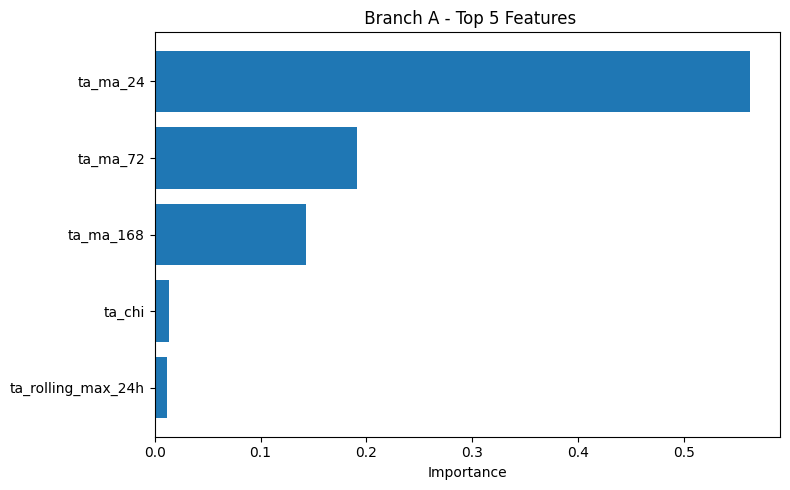

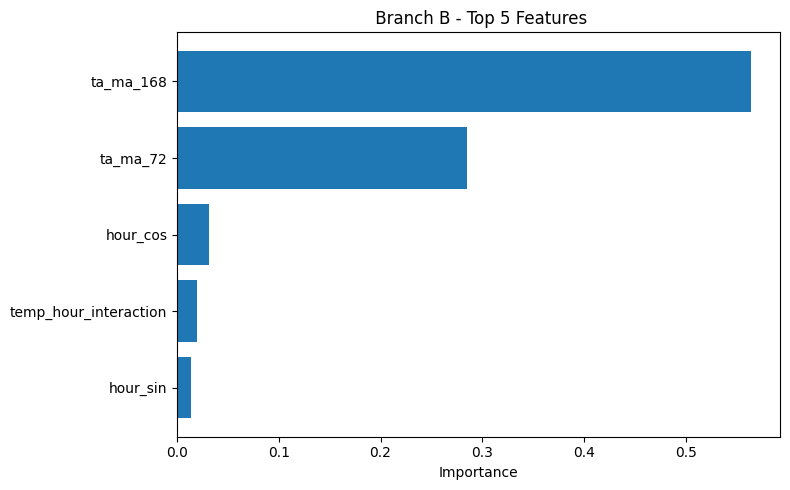

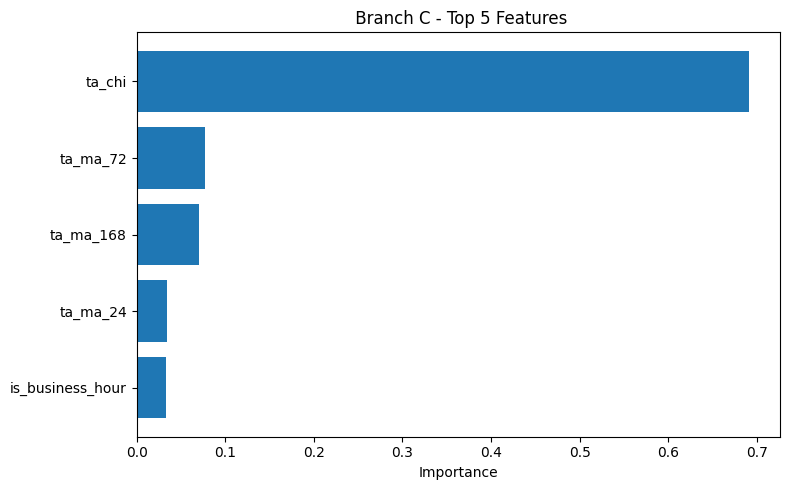

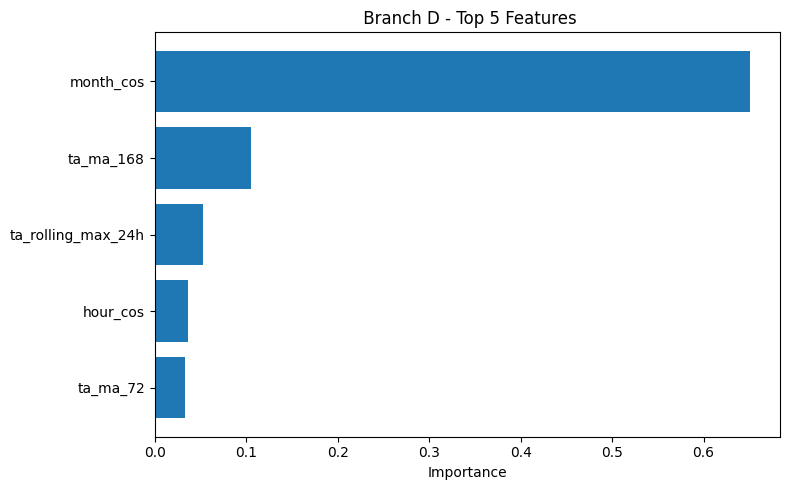

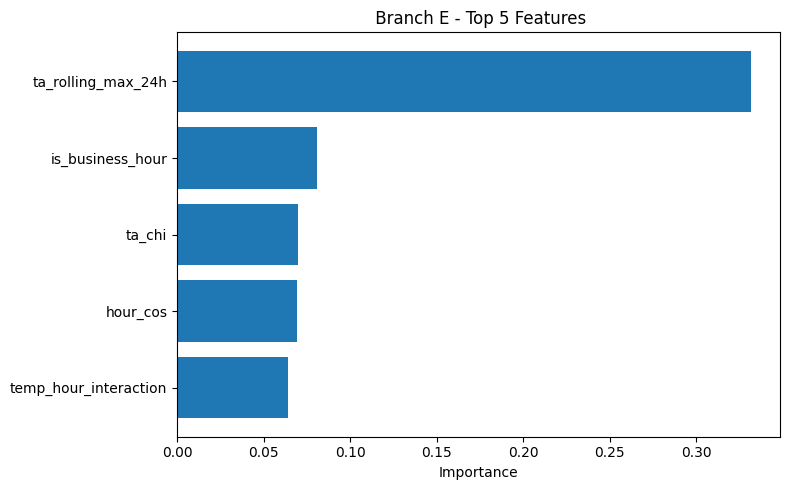

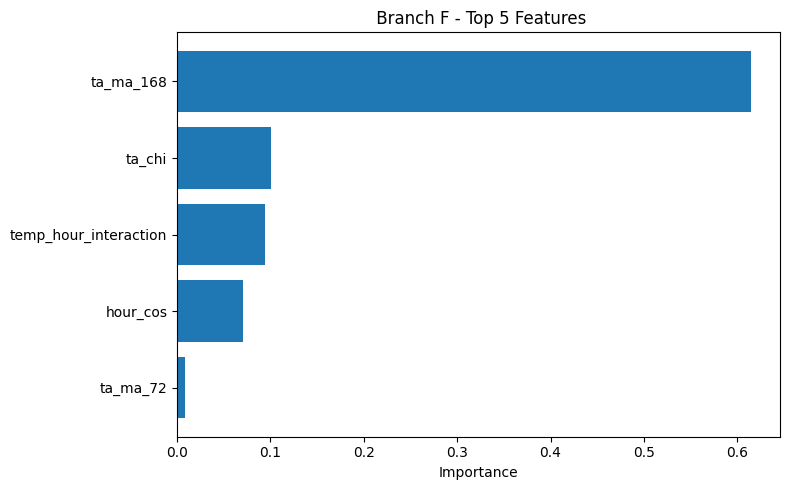

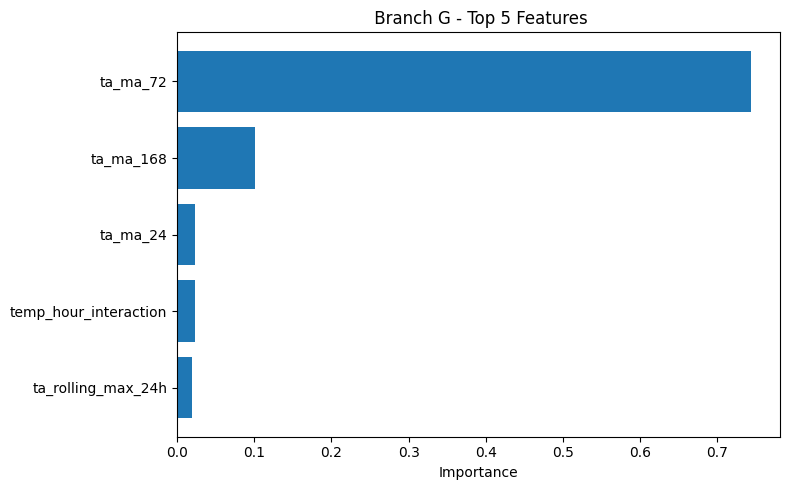

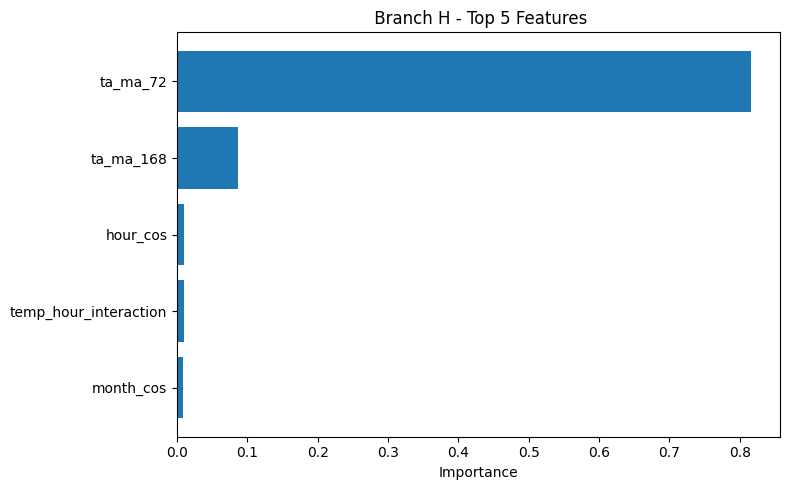

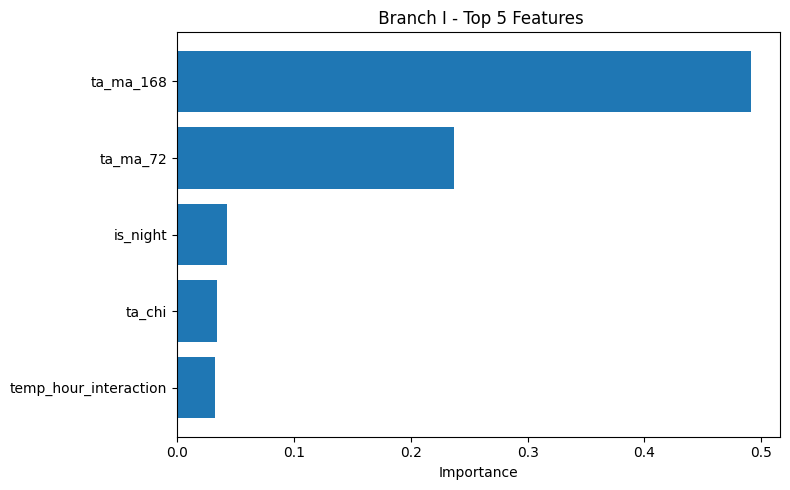

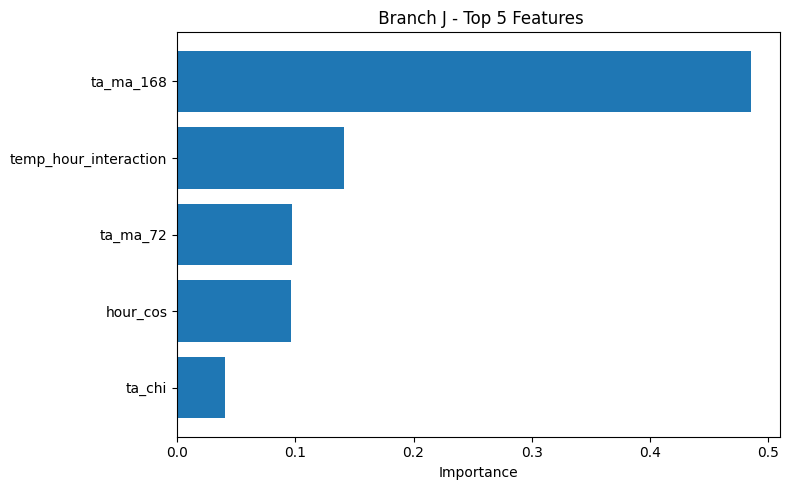

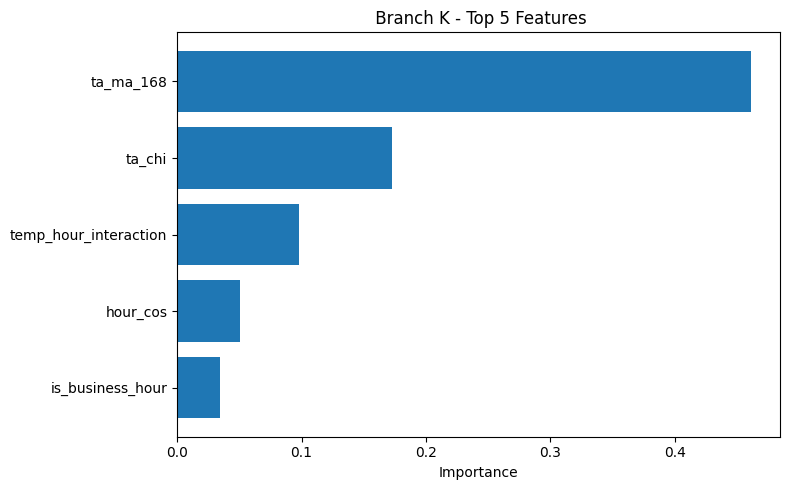

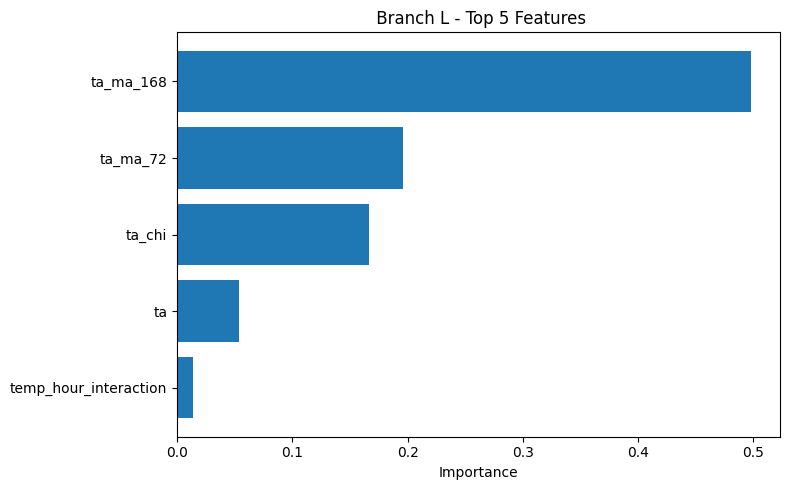

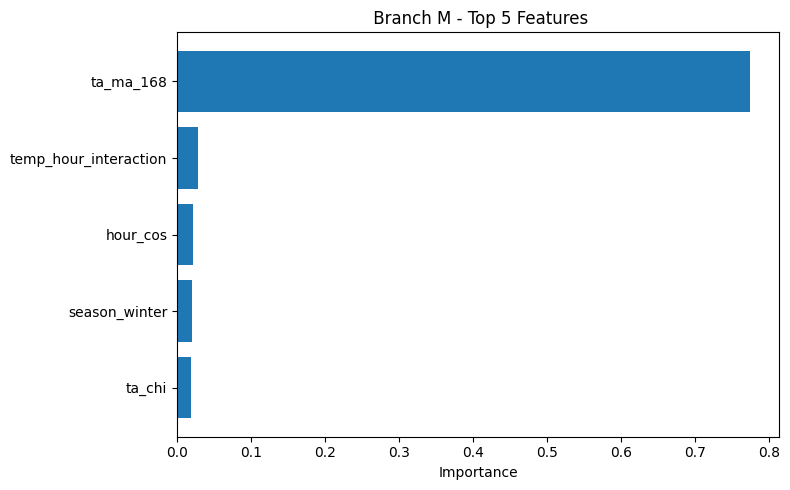

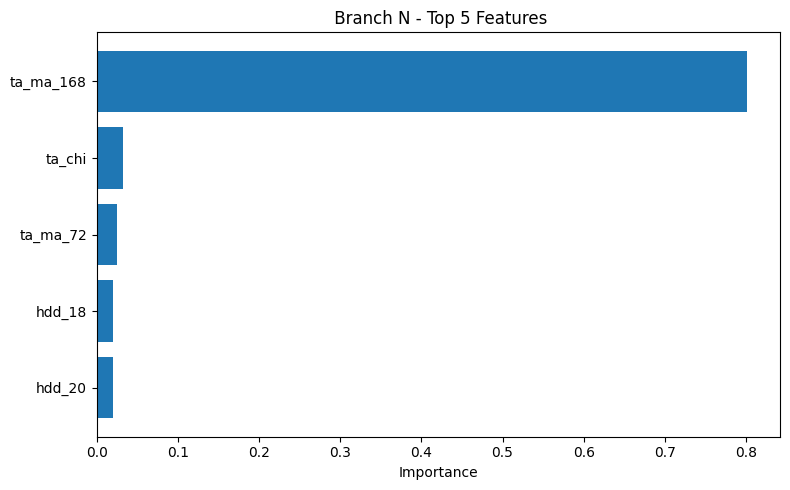

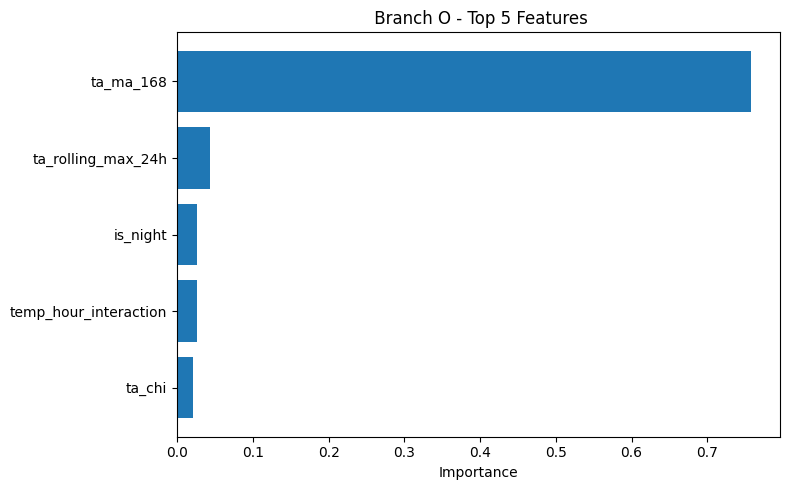

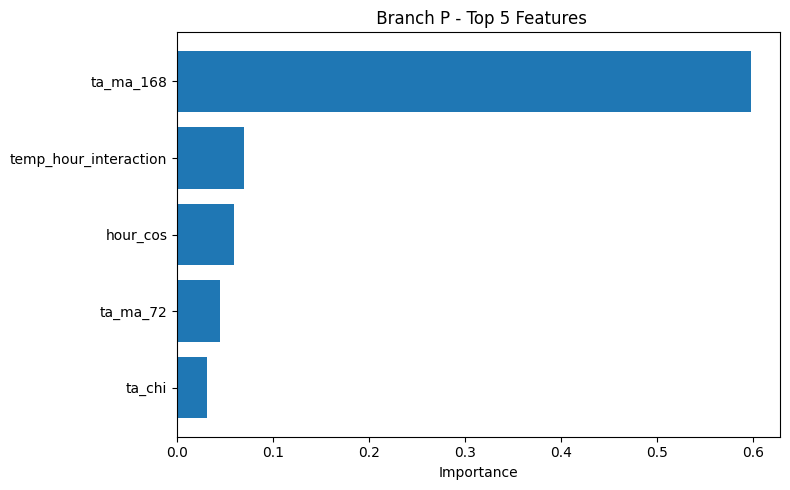

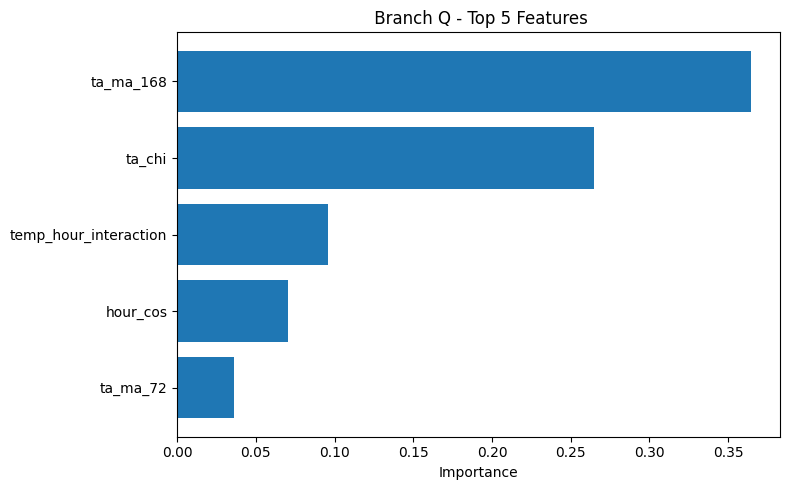

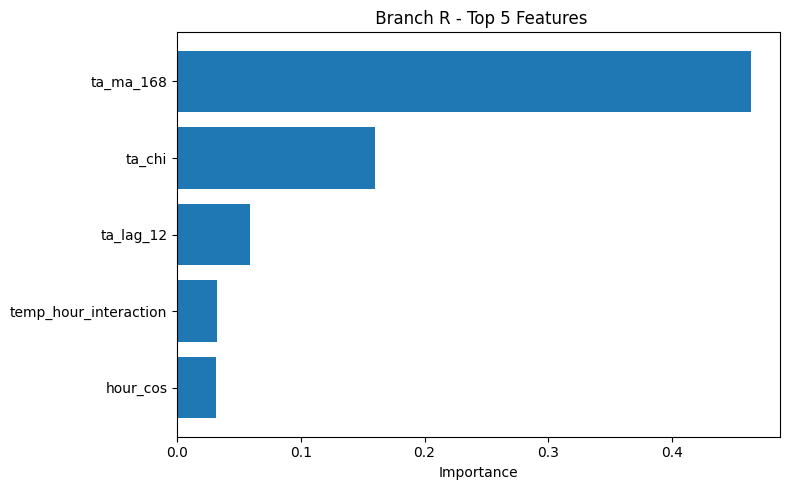

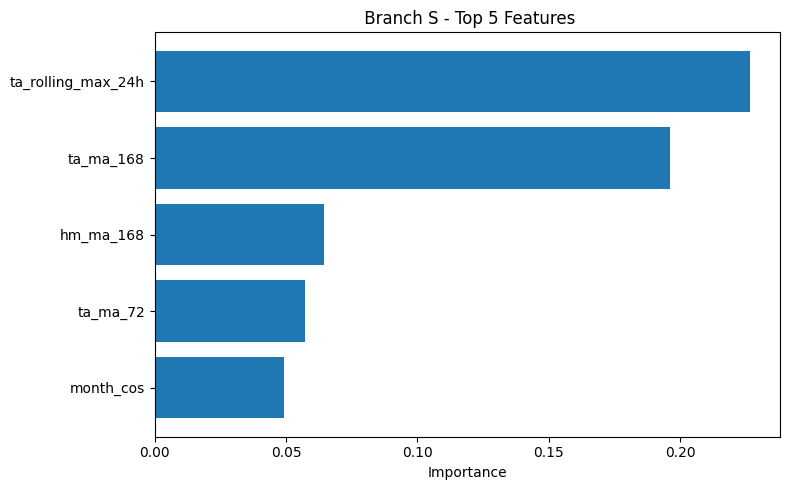

In [47]:
import matplotlib.pyplot as plt

def plot_feature_importance_by_branch(importance_df, top_n=5):
    branches = importance_df['branch'].unique()

    for branch in branches:
        # 해당 지점의 상위 top_n 중요 변수 선택
        df_branch = importance_df[importance_df['branch'] == branch]
        top_features = df_branch.sort_values(by='importance', ascending=False).head(top_n)

        # 그래프 그리기
        plt.figure(figsize=(8, 5))
        plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
        plt.xlabel('Importance')
        plt.title(f' Branch {branch} - Top {top_n} Features')
        plt.tight_layout()
        plt.show()

plot_feature_importance_by_branch(importance_df, top_n=5)

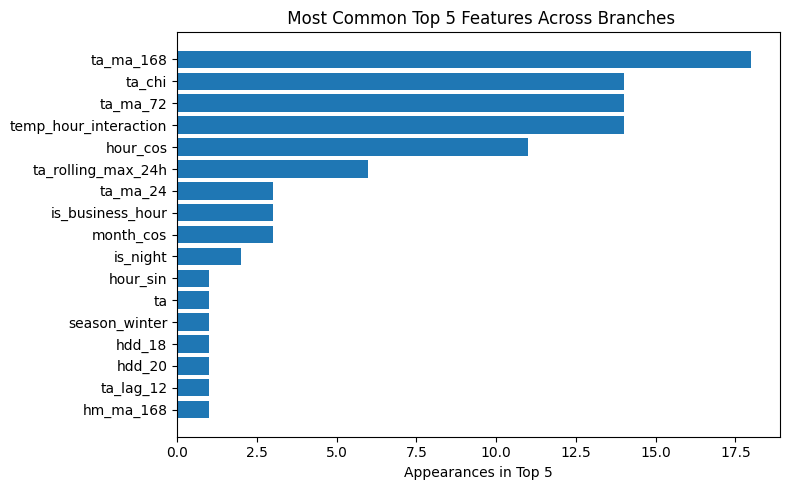

In [48]:
# 각 지점별 상위 5개 변수만 선택
topn_df = importance_df.groupby('branch').apply(lambda x: x.sort_values('importance', ascending=False).head(5))
topn_df = topn_df.reset_index(drop=True)

# 얼마나 자주 등장했는지 집계
feature_counts = topn_df['feature'].value_counts().reset_index()
feature_counts.columns = ['feature', 'count']

# 시각화
plt.figure(figsize=(8, 5))
plt.barh(feature_counts['feature'][::-1], feature_counts['count'][::-1])
plt.xlabel('Appearances in Top 5')
plt.title(' Most Common Top 5 Features Across Branches')
plt.tight_layout()
plt.show()

In [35]:
import pandas as pd
import numpy as np

def prepare_test_data(train_df, test_df, target_col='heat_demand_log'):

    # 최대 lag 기간 설정
    max_lag = 48

    # branch_id별로 처리
    test_processed_list = []

    for branch_id in test_df['branch_id'].unique():
        print(f"Processing branch_id: {branch_id}")

        # 각 branch별 train 마지막 부분과 test 연결
        train_branch = train_df[train_df['branch_id'] == branch_id].tail(max_lag).copy()
        test_branch = test_df[test_df['branch_id'] == branch_id].copy()

        # 연결
        combined = pd.concat([train_branch, test_branch], ignore_index=True)

        # Moving Average 변수 생성
        ma_periods = [12, 24, 72, 168]
        for col in ['ta', 'hm']:
            for period in ma_periods:
                combined[f'{col}_ma_{period}'] = combined[col].rolling(
                    window=period, min_periods=max(1, period//4)
                ).mean()

        # Percentage Change 변수 생성
        for col in ['ta', 'hm']:
            combined[f'{col}_pct_1h'] = combined[col].pct_change()
            combined[f'{col}_pct_6h'] = combined[col].pct_change(periods=6)
            combined[f'{col}_pct_24h'] = combined[col].pct_change(periods=24)

        # 시간 관련 변수 생성
        combined['hour'] = combined['tm'].dt.hour
        combined['month'] = combined['tm'].dt.month
        combined['weekday'] = combined['tm'].dt.weekday

        # 순환 인코딩 (Cyclical Encoding)
        combined['hour_sin'] = np.sin(2 * np.pi * combined['hour'] / 24)
        combined['hour_cos'] = np.cos(2 * np.pi * combined['hour'] / 24)
        combined['month_sin'] = np.sin(2 * np.pi * (combined['month'] - 1) / 12)
        combined['month_cos'] = np.cos(2 * np.pi * (combined['month'] - 1) / 12)
        combined['weekday_sin'] = np.sin(2 * np.pi * combined['weekday'] / 7)
        combined['weekday_cos'] = np.cos(2 * np.pi * combined['weekday'] / 7)

        # 시간대별 특성 변수
        combined['is_weekend'] = (combined['weekday'] >= 5).astype(int)
        combined['is_business_hour'] = ((combined['hour'] >= 9) & (combined['hour'] <= 18)).astype(int)
        combined['is_morning_peak'] = combined['hour'].isin([6, 7, 8, 9]).astype(int)
        combined['is_evening_peak'] = combined['hour'].isin([17, 18, 19, 20, 21]).astype(int)
        combined['is_night'] = ((combined['hour'] >= 22) | (combined['hour'] <= 5)).astype(int)

        # 날씨 관련 복합 변수

        # Wind Chill 계산
        combined['wind_chill'] = np.where(
            combined['ta'] <= 10,
            13.12 + 0.6215 * combined['ta'] - 11.37 * (combined['ws_log'] ** 0.16) +
            0.3965 * combined['ta'] * (combined['ws_log'] ** 0.16),
            combined['ta']
        )

        # Heating/Cooling Degree Days
        combined['hdd_18'] = np.maximum(18 - combined['ta'], 0)
        combined['hdd_20'] = np.maximum(20 - combined['ta'], 0)
        combined['cdd_26'] = np.maximum(combined['ta'] - 26, 0)

        # 계절 관련 변수
        combined['season_spring'] = combined['month'].isin([3, 4, 5]).astype(int)
        combined['season_summer'] = combined['month'].isin([6, 7, 8]).astype(int)
        combined['season_autumn'] = combined['month'].isin([9, 10, 11]).astype(int)
        combined['season_winter'] = combined['month'].isin([12, 1, 2]).astype(int)
        combined['heating_season'] = combined['month'].isin([10, 11, 12, 1, 2, 3, 4]).astype(int)

        # 상호작용 변수
        combined['temp_hour_interaction'] = combined['ta'] * combined['hour_sin']
        combined['temp_weekend_interaction'] = combined['ta'] * combined['is_weekend']
        combined['temp_season_interaction'] = combined['ta'] * combined['heating_season']
        combined['discomfort_index'] = combined['ta'] + 0.36 * combined['hm']

        # Rolling Statistics
        combined['ta_rolling_std_24h'] = combined['ta'].rolling(
            window=24, min_periods=6).std()

        combined['ta_rolling_max_24h'] = combined['ta'].rolling(
            window=24, min_periods=6).max()

        combined['ta_rolling_min_24h'] = combined['ta'].rolling(
            window=24, min_periods=6).min()

        combined['ta_daily_range'] = combined['ta_rolling_max_24h'] - combined['ta_rolling_min_24h']

        # 불필요한 컬럼 제거
        combined.drop(columns=['hour', 'month', 'weekday'], inplace=True)

        # Test 부분만 추출
        test_part = combined[len(train_branch):].copy()

        # 타겟 컬럼 제거 (test에는 없으므로)
        if target_col in test_part.columns:
            test_part = test_part.drop(target_col, axis=1)

        test_processed_list.append(test_part)

    # 모든 branch 결합
    test_processed = pd.concat(test_processed_list, ignore_index=True)

    # 13. 결측치 처리
    print(f"결측치 제거 전: {test_processed.shape[0]} 행")
    print(f"결측치 제거 후: {test_processed.shape[0]} 행")
    print(f"최종 컬럼 수: {test_processed.shape[1]}")

    return test_processed

In [36]:
import os
import joblib
import json
import numpy as np
import pandas as pd
from datetime import datetime

# 경로 설정
base_path = '/content/drive/MyDrive/공모전/250027'
save_path = '/content/drive/MyDrive/공모전/250027/Result/250027.csv'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# test 데이터에 로그 타겟 추가 (lag 계산용)
df_test['heat_demand_log'] = np.nan  # 순차 예측을 위해 필요

# test 데이터 전처리
test_processed = prepare_test_data(train_df=df_enhanced, test_df=df_test, target_col='heat_demand_log')

# 예측 결과 저장용 DataFrame
predictions = []

# 오늘 날짜
today_str = datetime.now().strftime('%Y%m%d')

# 저장된 모델 메타데이터 순회
for filename in os.listdir(base_path):
    if filename.startswith('rf_metadata') and filename.endswith('.json') and today_str in filename:
        with open(os.path.join(base_path, filename), 'r', encoding='utf-8') as f:
            meta = json.load(f)

        branch = meta['branch']
        feature_names = meta['feature_names']
        model_path = meta['model_path']

        print(f"\n▶ 예측 중: Branch {branch}")

        test_branch = test_processed[test_processed['branch_id'] == branch].copy()

        if test_branch.empty:
            print(f" 예측 건너뜀: Branch {branch} (샘플 없음)")
            continue

        # 누락된 feature 확인
        missing_cols = list(set(feature_names) - set(test_branch.columns))
        if missing_cols:
            print(f" 누락된 feature 컬럼: {missing_cols}")
            continue

        X_test = test_branch[feature_names].copy()
        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test.fillna(X_test.median(numeric_only=True), inplace=True)

        print(f" X_test shape: {X_test.shape}, feature 수: {len(feature_names)}")

        model = joblib.load(model_path)
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)

        # 길이 확인
        assert len(y_pred) == len(test_branch), f" 예측 결과와 데이터 길이 불일치: {len(y_pred)} vs {len(test_branch)}"

        # 예측 결과 저장
        test_branch['heat_demand'] = np.round(y_pred, 1)
        print(f" 예측 완료: {test_branch['heat_demand'].head().tolist()}")
        predictions.append(test_branch[['branch_id', 'tm', 'heat_demand']])

# 전체 예측 결과 병합
df_pred_all = pd.concat(predictions, ignore_index=True)
print(f"\n 전체 예측 병합 완료 → shape: {df_pred_all.shape}")
print(f"예측 결과 컬럼: {df_pred_all.columns.tolist()}")

# 원본 제출용 test 데이터에 예측값 반영
df_submit = pd.read_csv('/content/drive/MyDrive/공모전/dataset/test_heat.csv')
df_submit['TM'] = pd.to_datetime(df_submit['TM'], format='%Y%m%d%H')

# 병합 키 이름 통일
df_pred_all.rename(columns={'tm': 'TM', 'branch_id': 'branch_ID'}, inplace=True)

# 병합 시도
df_result = df_submit.merge(df_pred_all, on=['branch_ID', 'TM'], how='left')
print(f"병합 후 컬럼 목록: {df_result.columns.tolist()}")

# heat_demand 컬럼 확인 및 정리
if 'heat_demand_y' in df_result.columns:
    df_result.drop(columns=['heat_demand_x'], errors='ignore', inplace=True)
    df_result.rename(columns={'heat_demand_y': 'heat_demand'}, inplace=True)
elif 'heat_demand' not in df_result.columns:
    raise ValueError(" 병합 후 heat_demand 컬럼이 존재하지 않습니다. 병합이 실패했거나 예측값이 없습니다.")

# 반올림
df_result['heat_demand'] = df_result['heat_demand'].round(1)

# TM을 문자열로 원래 제출 형식대로 변환
df_result['TM'] = df_result['TM'].dt.strftime('%Y%m%d%H')

# 저장
df_result.to_csv(save_path, index=False, float_format='%.1f')
print(f"\n 예측 완료 및 저장 → {save_path}")

Processing branch_id: A
Processing branch_id: B
Processing branch_id: C
Processing branch_id: D
Processing branch_id: E
Processing branch_id: F
Processing branch_id: G
Processing branch_id: H
Processing branch_id: I
Processing branch_id: J
Processing branch_id: K
Processing branch_id: L
Processing branch_id: M
Processing branch_id: N
Processing branch_id: O
Processing branch_id: P
Processing branch_id: Q
Processing branch_id: R
Processing branch_id: S
결측치 제거 전: 166915 행
결측치 제거 후: 166915 행
최종 컬럼 수: 70

▶ 예측 중: Branch A
 X_test shape: (8785, 66), feature 수: 66
 예측 완료: [236.5, 234.5, 233.7, 233.3, 235.8]

▶ 예측 중: Branch B
 X_test shape: (8785, 66), feature 수: 66
 예측 완료: [520.2, 493.8, 487.1, 478.3, 469.3]

▶ 예측 중: Branch C
 X_test shape: (8785, 66), feature 수: 66
 예측 완료: [571.4, 535.7, 524.2, 502.0, 485.8]

▶ 예측 중: Branch D
 X_test shape: (8785, 66), feature 수: 66
 예측 완료: [324.9, 319.6, 315.6, 312.4, 315.1]

▶ 예측 중: Branch E
 X_test shape: (8785, 66), feature 수: 66
 예측 완료: [98.5, 94.1, 89